#### 基本設置 + 設cuda

In [25]:
# Load in relevant libraries, and alias where appropriate
import torch
import torch.nn as nn
import torchvision.transforms as transforms

# Define relevant variables for the ML task
batch_size = 4
num_classes = 2
learning_rate = 1e-5
num_epochs = 30

# Device will determine whether to run the training on GPU or CPU.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


#### 讀取資料集

In [26]:
import os
import numpy as np
import cv2
from PIL import Image
from torch.utils.data import Dataset, DataLoader, Subset

# 定义数据转换
transform = transforms.Compose([
    # transforms.Resize((480, 256)),  # fixed image dimension
    transforms.ToTensor(),           # make np to tensor
])

# dataset
class MEL_Dataset(Dataset):
    def __init__(self, mel_folder, transform=None, dataAug=False):
        self.melfolder = mel_folder
        self.mel_file = os.listdir(mel_folder)
        self.transform = transform
        self.dataAug = dataAug
    def __len__(self):
        return len(self.mel_file)
    def __getitem__(self, idx):
        mel_file = self.mel_file[idx]
        # 範例：載入 precomputed mel tensor (n_mel, SPEC_WIDTH)
        filepath = os.path.join(self.melfolder, mel_file)
        mel = Image.open(filepath).convert('RGB')
        # make into binary classificaton
        idx = 1 if self.dataAug else 0
        label = 0 if int(mel_file.split('_')[idx]) < 5 else 1  # 假設標籤是文件名稱的一部分
        if self.transform:
            mel = self.transform(mel)
        return mel, label


# 獲取相關信息
source_folder = '../dataset/mel_spectrograms'
dataset = MEL_Dataset(source_folder, transform=transform)
dataloader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True)
# DataLoader for batching
for i, (mel, label) in enumerate(dataloader):
    # 在這裡進行訓練或驗證
    print(f"Batch {i}: MEL shape: {mel.shape}, Label: {label}")
    break

Batch 0: MEL shape: torch.Size([4, 3, 369, 496]), Label: tensor([0, 0, 0, 1])


In [27]:
aug_source_folder = '../dataset/aug_mel_spectrograms'
aug_dataset = MEL_Dataset(aug_source_folder, transform=transform, dataAug=True)
for i, (mel, label) in enumerate(dataloader):
    # 在這裡進行訓練或驗證
    print(len(aug_dataset))
    print(f"Batch {i}: MEL shape: {mel.shape}, Label: {label}")
    break

410
Batch 0: MEL shape: torch.Size([4, 3, 369, 496]), Label: tensor([0, 0, 0, 0])


Group-K fold cross validation

In [28]:
import numpy as np
from sklearn.model_selection import GroupKFold
from torch.utils.data import Subset, DataLoader, ConcatDataset

def create_group_kfold_loaders(dataset, batch_size, n_splits=5, dataAug=None):
    """
    Split dataset using GroupKFold based on video names.
    Returns list of (train_loader, test_loader) tuples for each fold.
    """
    # Extract filenames to create groups
    mfcc_files = dataset.mel_file  # Assuming mel_file contains filenames like 'label_videoname_segment.npy'
    filenames = []
    groups = []
    labels = []
    
    for file in mfcc_files:
        # Extract video name (assuming format: label_videoname_segment.npy)
        filename = file.split('_')[1]  # Get the video name part
        filenames.append(filename)
        labels.append(0 if int(file.split('_')[0]) < 5 else 1)
    
    # Convert filenames to group indices
    unique_filenames = list(set(filenames))
    groups = [unique_filenames.index(fname) for fname in filenames]
    
    # Create indices for GroupKFold
    indices = np.arange(len(dataset))
    
    # Initialize GroupKFold
    group_kfold = GroupKFold(n_splits=n_splits)
    
    # Create loaders for each fold
    fold_loaders = []
    for fold_idx, (train_idx, test_idx) in enumerate(group_kfold.split(indices, labels, groups)):
        # Create subsets for train and test
        # select specific range of data
        train_subset = Subset(dataset, train_idx)
        # merge with data augmentation data
        if dataAug is not None:
            train_subset = ConcatDataset([train_subset, dataAug])
        test_subset = Subset(dataset, test_idx)
        
        # Create DataLoaders
        train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
        test_loader = DataLoader(test_subset, batch_size=batch_size, shuffle=False)
        
        fold_loaders.append((train_loader, test_loader, fold_idx))
    
    return fold_loaders

# Example usage
if __name__ == '__main__':
    fold_loaders = create_group_kfold_loaders(dataset, batch_size)
    
    # Now you can iterate through folds
    for train_loader, test_loader, fold_idx in fold_loaders:
        print(f"Fold {fold_idx}:")
        print(f"  Training samples: {len(train_loader.dataset)}")
        print(f"  Testing samples: {len(test_loader.dataset)}")

Fold 0:
  Training samples: 328
  Testing samples: 82
Fold 1:
  Training samples: 328
  Testing samples: 82
Fold 2:
  Training samples: 328
  Testing samples: 82
Fold 3:
  Training samples: 328
  Testing samples: 82
Fold 4:
  Training samples: 328
  Testing samples: 82


#### 創立model

In [29]:
import torch.nn.functional as F
# Create CNN Model
class CNN_Model(nn.Module):
    def __init__(self):
        super(CNN_Model, self).__init__()
        # Convolution , input_shape=(3,369,496)
        self.layer1 = self.input_processing_block(3, 16) #output_shape=(16,184,248)

        # 依序定義 channel 變化
        self.channel_list = [16, 64, 32, 16, 8]

        self.res_blocks = nn.ModuleList()
        for i in range(len(self.channel_list)-1):
            in_c = self.channel_list[i]
            out_c = self.channel_list[i+1]
            self.res_blocks.append(nn.ModuleDict({
                'conv': self.conv_block(in_c, out_c),
                'res': self.residue_block(in_c, out_c)
            }))

        # 用 dummy 計算 flatten_size
        with torch.no_grad():
            dummy = torch.zeros(1, 3, 369, 496)
            out = self.layer1(dummy)
            for block in self.res_blocks:
                conv_out = block['conv'](out)
                res_out = block['res'](out)
                out = conv_out + res_out
                out = F.relu(out)
                out = nn.MaxPool2d(kernel_size=2)(out)
            self.flatten_size = out.view(1, -1).shape[1]
        # output_shape = (8, 23, 31)

        # final layers
        self.layer3 = self.classification_block(self.flatten_size, 512) #output_shape=(2,)

    def forward(self, x):
        # Convolutions
        out = self.layer1(x)

        # Apply residual connections
        for block in self.res_blocks:
            conv_out = block['conv'](out)
            res_out = block['res'](out)
            out = conv_out + res_out
            out = F.relu(out)
            out = nn.MaxPool2d(kernel_size=2)(out)

        out = self.layer3(out)

        return out
    
    def input_processing_block(self, in_channels, out_channels):
        "By giving the convolutional parameters, the function will return a convolutional module"
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=5, padding='same'),
            nn.ReLU(),
            nn.BatchNorm2d(out_channels),
            nn.MaxPool2d(kernel_size=2)
        )
    def conv_block(self, in_channels, out_channels):
        "By giving the convolutional parameters, the function will return a convolutional module"
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1),    # expand the channels
            nn.ReLU(),
            nn.BatchNorm2d(out_channels),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.BatchNorm2d(out_channels),
        )
    def residue_block(self, in_channels, out_channels):
        "By giving the parameters, the function will return a residual module"
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1),    # expand the channels
            nn.ReLU(),
            nn.BatchNorm2d(out_channels),
        )

    def classification_block(self, in_channels, out_channels):
        "By giving the parameters, the function will return a classification module"
        return nn.Sequential(
            nn.Dropout(0.3),  # dropout layer
            nn.Flatten(),  # flatten the output
            nn.Linear(in_channels, out_channels),  # fully connected layer
            nn.ReLU(),
            nn.BatchNorm1d(out_channels),
            nn.Dropout(0.3),
            nn.Linear(out_channels, num_classes)  # final output layer
        )

In [30]:
import torchinfo

model = CNN_Model()
test_input = torch.randn(1, 3, 369, 496)  # Example input tensor
print(f"Model's structure:\n {torchinfo.summary(model, input_size=test_input.shape)}")

Model's structure:
Layer (type:depth-idx)                   Output Shape              Param #
CNN_Model                                [1, 2]                    --
├─Sequential: 1-1                        [1, 16, 184, 248]         --
│    └─Conv2d: 2-1                       [1, 16, 369, 496]         1,216
│    └─ReLU: 2-2                         [1, 16, 369, 496]         --
│    └─BatchNorm2d: 2-3                  [1, 16, 369, 496]         32
│    └─MaxPool2d: 2-4                    [1, 16, 184, 248]         --
├─ModuleList: 1-2                        --                        --
│    └─ModuleDict: 2-5                   --                        --
│    │    └─Sequential: 3-1              [1, 64, 184, 248]         38,272
│    │    └─Sequential: 3-2              [1, 64, 184, 248]         1,216
│    └─ModuleDict: 2-6                   --                        --
│    │    └─Sequential: 3-3              [1, 32, 92, 124]          11,456
│    │    └─Sequential: 3-4              [1, 32, 92,

#### 訓練模型

In [31]:
import random
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

In [32]:
from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report

def training(train_loader, test_loader, optimizer, num_epochs):
    # accumlated loss to visuallized
    train_losses = []
    train_accuracies = []
    valid_losses = []
    valid_accuracies = []

    # Training
    model = CNN_Model().to(device)
    optimizer = optimizer
    criterion = nn.CrossEntropyLoss()
    
    # Example training loop (simplified)
    for epoch in range(1, num_epochs+1):
        # Train mode
        model.train()
        train_loss = 0.0
        correct = 0
        total = 0
        train_bar = tqdm(train_loader, desc=f"Training Epoch {epoch}/{num_epochs}")

        for iter, (input, target) in enumerate(train_bar):
            # Move data to "device".
            input = input.to(device)
            target = target.to(device)
            # Clear optimizer gradients.
            optimizer.zero_grad()
            
            # Forward pass.
            output = model(input)
            # Compute the loss.
            loss = criterion(output, target)
            # Loss backward propagation.
            loss.backward()
            # Update all learnable parameters.
            optimizer.step()
            # update training loss
            train_loss += loss.item()

            # predicted
            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

            # Update progress bar
            train_bar.set_description(f'Epoch: {epoch}/{num_epochs} | train loss: {train_loss / total:.4f} | train accuracy: {100 * correct / total:.2f}%')

        # Calculate average training loss
        avg_train_loss = train_loss / len(train_loader.dataset)
        train_losses.append(avg_train_loss)  # Store average loss for visualization
        
        # Calculate average training accuracies
        accuracy = 100 * correct / total
        train_accuracies.append(accuracy)

        # Evaluate
        model.eval()
        BestValid = 0
        valid_loss = 0.0
        correct = 0
        total = 0
        
        valid_bar = tqdm(test_loader, desc=f"Validating Epoch {epoch}/{num_epochs}")
        with torch.no_grad():
            for inputs, targets in valid_bar:
                # run test
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs) # (batch_size, num_classes)
                # loss
                loss = criterion(outputs, targets)
                valid_loss += loss.item()
                # predicted
                _, predicted = torch.max(outputs.data, 1)
                total += targets.size(0)
                correct += (predicted == targets).sum().item()

                # Update progress bar
                valid_bar.set_description(
                                            f"Epoch: {epoch}/{num_epochs} "
                                            f"| valid loss: {valid_loss / total:.4f} "
                                            f"| valid accuracy: {100 * correct / total:.2f}% "
                                        )
            
            if accuracy > BestValid:
                BestValid = accuracy
                BestValidModel = model

        # Calculate average validation loss and accuracy
        avg_valid_loss = valid_loss / len(test_loader.dataset)
        accuracy = 100 * correct / total
        
        valid_losses.append(avg_valid_loss)
        valid_accuracies.append(accuracy)

    return BestValidModel, train_losses, train_accuracies, valid_losses, valid_accuracies

In [33]:
import matplotlib.pyplot as plt

def plot_training_history(train_losses, train_accuracies, valid_losses, valid_accuracies):
    # Plot training and validation loss
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(valid_losses, label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot training and validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Training Accuracy')
    plt.plot(valid_accuracies, label='Validation Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
# File name.
modelSaveName = "MELModel_dataAug.pt"
# model
model = CNN_Model().to(device)
# Create an optimizer.
optimizer = torch.optim.AdamW(params=model.parameters(), lr=learning_rate)
# Create a loss function
lossFunc = nn.CrossEntropyLoss()

BestValid_Acc = 0
Bestfold = 0
fold_loaders = create_group_kfold_loaders(dataset, batch_size, n_splits=5, dataAug=aug_dataset)
for train, test, idx in fold_loaders:
    print(f"Fold {idx}: Training samples: {len(train.dataset)}, Testing samples: {len(test.dataset)}")
    model, train_losses, train_accuracies, valid_losses, valid_accuracies = training(train, test, optimizer, num_epochs)
    print()

    # Print statistics for this fold
    all_targets = []
    all_predictions = []
    all_probs = []
    
    # Set model to evaluation mode
    model.eval()
    
    # Collect predictions for test data
    with torch.no_grad():
        for inputs, targets in test:
            # Move data to device
            inputs, targets = inputs.to(device), targets.to(device)
            
            # Forward pass
            outputs = model(inputs)
            
            # Get predictions
            _, predicted = torch.max(outputs.data, 1)
            
            # Get probability scores for ROC AUC
            probs = torch.nn.functional.softmax(outputs, dim=1).cpu().numpy()[:, 1]  # Probability for positive class
            
            # Store results for metrics calculation
            all_targets.extend(targets.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
            all_probs.extend(probs)
    
    # Calculate metrics
    try:
        roc_auc_score_value = roc_auc_score(all_targets, all_probs)
    except ValueError:
        # Handle case when only one class is present in targets
        roc_auc_score_value = 0.5
    
    # Generate confusion matrix
    cm = confusion_matrix(all_targets, all_predictions)
    
    # Print detailed metrics
    print(f"\nFold {idx} Test Results:")
    
    print(f"Classification Report:\n{classification_report(all_targets, all_predictions, zero_division=np.nan)}")
    print(f"Accuracy: {accuracy_score(all_targets, all_predictions):.4f}")
    print(f"Precision: {precision_score(all_targets, all_predictions):.4f}")
    print(f"Recall: {recall_score(all_targets, all_predictions):.4f}")
    print(f"F1 Score: {f1_score(all_targets, all_predictions):.4f}")
    print(f"ROC AUC Score: {roc_auc_score_value:.4f}")
    print(f"Confusion Matrix:\n{cm}")

    # Plot the training history
    plot_training_history(train_losses, train_accuracies, valid_losses, valid_accuracies)
    plt.show()

    # Check for best validation accuracy to store best model
    if max(valid_accuracies) > BestValid_Acc:
        BestValid_Acc = max(valid_accuracies)
        Bestfold = idx
        modelToSave = model


# 存檔
print(f"Best Validation Accuracy: {BestValid_Acc:.2f}% in Fold {Bestfold}")
torch.save(modelToSave.state_dict(), modelSaveName)
print('Model saved to %s' % modelSaveName)

Test Adam

Fold 0: Training samples: 738, Testing samples: 82


Epoch: 1/30 | train loss: 0.1915 | train accuracy: 51.76%: 100%|██████████| 185/185 [00:23<00:00,  7.97it/s]
Epoch: 1/30 | valid loss: 0.1914 | valid accuracy: 48.78% : 100%|██████████| 21/21 [00:01<00:00, 14.31it/s]
Epoch: 2/30 | train loss: 0.1921 | train accuracy: 51.63%: 100%|██████████| 185/185 [00:24<00:00,  7.68it/s]
Epoch: 2/30 | valid loss: 0.1741 | valid accuracy: 62.20% : 100%|██████████| 21/21 [00:01<00:00, 13.78it/s]
Epoch: 3/30 | train loss: 0.1924 | train accuracy: 49.19%: 100%|██████████| 185/185 [00:23<00:00,  8.03it/s]
Epoch: 3/30 | valid loss: 0.1700 | valid accuracy: 59.76% : 100%|██████████| 21/21 [00:01<00:00, 12.62it/s]
Epoch: 4/30 | train loss: 0.1900 | train accuracy: 54.34%: 100%|██████████| 185/185 [00:23<00:00,  7.98it/s]
Epoch: 4/30 | valid loss: 0.1809 | valid accuracy: 57.32% : 100%|██████████| 21/21 [00:01<00:00, 13.81it/s]
Epoch: 5/30 | train loss: 0.1949 | train accuracy: 49.59%: 100%|██████████| 185/185 [00:22<00:00,  8.24it/s]
Epoch: 5/30 | valid los

d:\ancode\envs\torch\Lib\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(



Fold 0 Test Results:
Classification Report:
              precision    recall  f1-score   support

           0       0.00       nan      0.00         0
           1       1.00      0.50      0.67        82

    accuracy                           0.50        82
   macro avg       0.50      0.50      0.33        82
weighted avg       1.00      0.50      0.67        82

Accuracy: 0.5000
Precision: 1.0000
Recall: 0.5000
F1 Score: 0.6667
ROC AUC Score: nan
Confusion Matrix:
[[ 0  0]
 [41 41]]


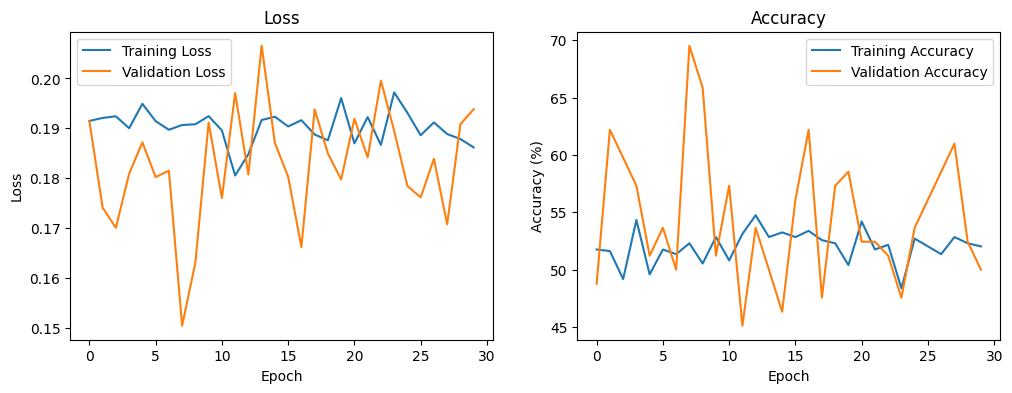

Fold 1: Training samples: 738, Testing samples: 82


Epoch: 1/30 | train loss: 0.1905 | train accuracy: 53.12%: 100%|██████████| 185/185 [00:22<00:00,  8.06it/s]
Epoch: 1/30 | valid loss: 0.2090 | valid accuracy: 32.93% : 100%|██████████| 21/21 [00:01<00:00, 14.26it/s]
Epoch: 2/30 | train loss: 0.1919 | train accuracy: 52.71%: 100%|██████████| 185/185 [00:22<00:00,  8.08it/s]
Epoch: 2/30 | valid loss: 0.2292 | valid accuracy: 28.05% : 100%|██████████| 21/21 [00:01<00:00, 13.75it/s]
Epoch: 3/30 | train loss: 0.1934 | train accuracy: 51.22%: 100%|██████████| 185/185 [00:22<00:00,  8.16it/s]
Epoch: 3/30 | valid loss: 0.2468 | valid accuracy: 21.95% : 100%|██████████| 21/21 [00:01<00:00, 14.42it/s]
Epoch: 4/30 | train loss: 0.1924 | train accuracy: 53.39%: 100%|██████████| 185/185 [00:22<00:00,  8.29it/s]
Epoch: 4/30 | valid loss: 0.2082 | valid accuracy: 31.71% : 100%|██████████| 21/21 [00:01<00:00, 14.24it/s]
Epoch: 5/30 | train loss: 0.1923 | train accuracy: 51.22%: 100%|██████████| 185/185 [00:22<00:00,  8.09it/s]
Epoch: 5/30 | valid los



Fold 1 Test Results:
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.20      0.33        75
           1       0.09      0.86      0.16         7

    accuracy                           0.26        82
   macro avg       0.51      0.53      0.25        82
weighted avg       0.87      0.26      0.32        82

Accuracy: 0.2561
Precision: 0.0909
Recall: 0.8571
F1 Score: 0.1644
ROC AUC Score: 0.7048
Confusion Matrix:
[[15 60]
 [ 1  6]]


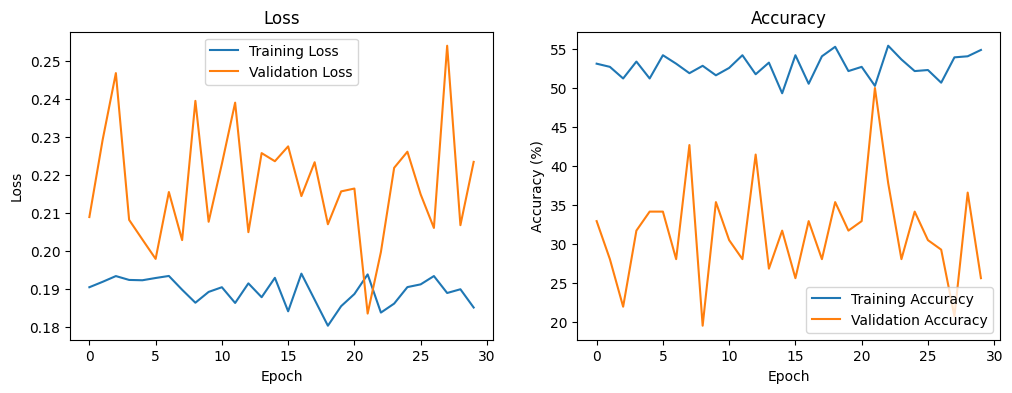

Fold 2: Training samples: 738, Testing samples: 82


Epoch: 1/30 | train loss: 0.2079 | train accuracy: 45.53%: 100%|██████████| 185/185 [00:22<00:00,  8.18it/s]
Epoch: 1/30 | valid loss: 0.1682 | valid accuracy: 65.85% : 100%|██████████| 21/21 [00:01<00:00, 14.73it/s]
Epoch: 2/30 | train loss: 0.2028 | train accuracy: 48.92%: 100%|██████████| 185/185 [00:22<00:00,  8.20it/s]
Epoch: 2/30 | valid loss: 0.1593 | valid accuracy: 65.85% : 100%|██████████| 21/21 [00:01<00:00, 14.48it/s]
Epoch: 3/30 | train loss: 0.1965 | train accuracy: 50.95%: 100%|██████████| 185/185 [00:22<00:00,  8.25it/s]
Epoch: 3/30 | valid loss: 0.1620 | valid accuracy: 60.98% : 100%|██████████| 21/21 [00:01<00:00, 14.02it/s]
Epoch: 4/30 | train loss: 0.1955 | train accuracy: 52.30%: 100%|██████████| 185/185 [00:22<00:00,  8.19it/s]
Epoch: 4/30 | valid loss: 0.1491 | valid accuracy: 69.51% : 100%|██████████| 21/21 [00:01<00:00, 14.10it/s]
Epoch: 5/30 | train loss: 0.2020 | train accuracy: 47.43%: 100%|██████████| 185/185 [00:22<00:00,  8.18it/s]
Epoch: 5/30 | valid los



Fold 2 Test Results:
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.59      0.74        73
           1       0.21      0.89      0.34         9

    accuracy                           0.62        82
   macro avg       0.59      0.74      0.54        82
weighted avg       0.89      0.62      0.69        82

Accuracy: 0.6220
Precision: 0.2105
Recall: 0.8889
F1 Score: 0.3404
ROC AUC Score: 0.7991
Confusion Matrix:
[[43 30]
 [ 1  8]]


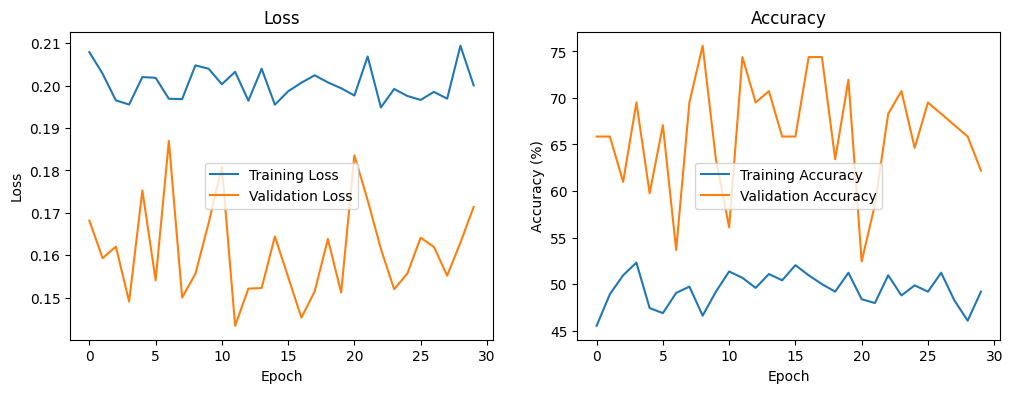

Fold 3: Training samples: 738, Testing samples: 82


Epoch: 1/30 | train loss: 0.1871 | train accuracy: 51.63%: 100%|██████████| 185/185 [00:22<00:00,  8.11it/s]
Epoch: 1/30 | valid loss: 0.1806 | valid accuracy: 52.44% : 100%|██████████| 21/21 [00:01<00:00, 13.75it/s]
Epoch: 2/30 | train loss: 0.1908 | train accuracy: 51.36%: 100%|██████████| 185/185 [00:24<00:00,  7.47it/s]
Epoch: 2/30 | valid loss: 0.1952 | valid accuracy: 48.78% : 100%|██████████| 21/21 [00:01<00:00, 13.79it/s]
Epoch: 3/30 | train loss: 0.1878 | train accuracy: 53.25%: 100%|██████████| 185/185 [00:22<00:00,  8.13it/s]
Epoch: 3/30 | valid loss: 0.2058 | valid accuracy: 41.46% : 100%|██████████| 21/21 [00:01<00:00, 13.90it/s]
Epoch: 4/30 | train loss: 0.1916 | train accuracy: 48.92%: 100%|██████████| 185/185 [00:22<00:00,  8.16it/s]
Epoch: 4/30 | valid loss: 0.1934 | valid accuracy: 52.44% : 100%|██████████| 21/21 [00:01<00:00, 14.71it/s]
Epoch: 5/30 | train loss: 0.1945 | train accuracy: 49.32%: 100%|██████████| 185/185 [00:22<00:00,  8.25it/s]
Epoch: 5/30 | valid los



Fold 3 Test Results:
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.51      0.65        73
           1       0.12      0.56      0.20         9

    accuracy                           0.51        82
   macro avg       0.51      0.53      0.42        82
weighted avg       0.82      0.51      0.60        82

Accuracy: 0.5122
Precision: 0.1220
Recall: 0.5556
F1 Score: 0.2000
ROC AUC Score: 0.5464
Confusion Matrix:
[[37 36]
 [ 4  5]]


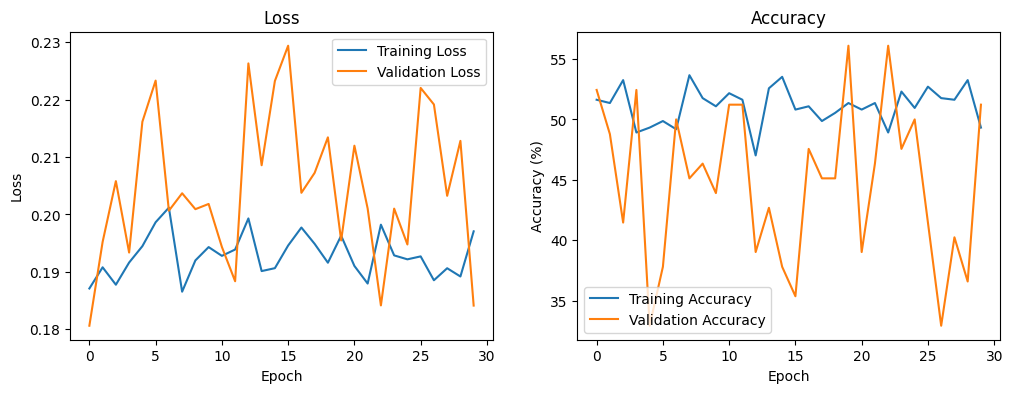

Fold 4: Training samples: 738, Testing samples: 82


Epoch: 1/30 | train loss: 0.1835 | train accuracy: 53.52%: 100%|██████████| 185/185 [00:22<00:00,  8.21it/s]
Epoch: 1/30 | valid loss: 0.1924 | valid accuracy: 43.90% : 100%|██████████| 21/21 [00:01<00:00, 14.64it/s]
Epoch: 2/30 | train loss: 0.1867 | train accuracy: 52.30%: 100%|██████████| 185/185 [00:22<00:00,  8.22it/s]
Epoch: 2/30 | valid loss: 0.2039 | valid accuracy: 43.90% : 100%|██████████| 21/21 [00:01<00:00, 14.91it/s]
Epoch: 3/30 | train loss: 0.1828 | train accuracy: 55.83%: 100%|██████████| 185/185 [00:22<00:00,  8.17it/s]
Epoch: 3/30 | valid loss: 0.1854 | valid accuracy: 48.78% : 100%|██████████| 21/21 [00:01<00:00, 13.44it/s]
Epoch: 4/30 | train loss: 0.1860 | train accuracy: 54.74%: 100%|██████████| 185/185 [00:22<00:00,  8.22it/s]
Epoch: 4/30 | valid loss: 0.1862 | valid accuracy: 48.78% : 100%|██████████| 21/21 [00:01<00:00, 14.64it/s]
Epoch: 5/30 | train loss: 0.1891 | train accuracy: 52.03%: 100%|██████████| 185/185 [00:22<00:00,  8.19it/s]
Epoch: 5/30 | valid los



Fold 4 Test Results:
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.25      0.38        73
           1       0.10      0.67      0.17         9

    accuracy                           0.29        82
   macro avg       0.48      0.46      0.28        82
weighted avg       0.77      0.29      0.36        82

Accuracy: 0.2927
Precision: 0.0984
Recall: 0.6667
F1 Score: 0.1714
ROC AUC Score: 0.5936
Confusion Matrix:
[[18 55]
 [ 3  6]]


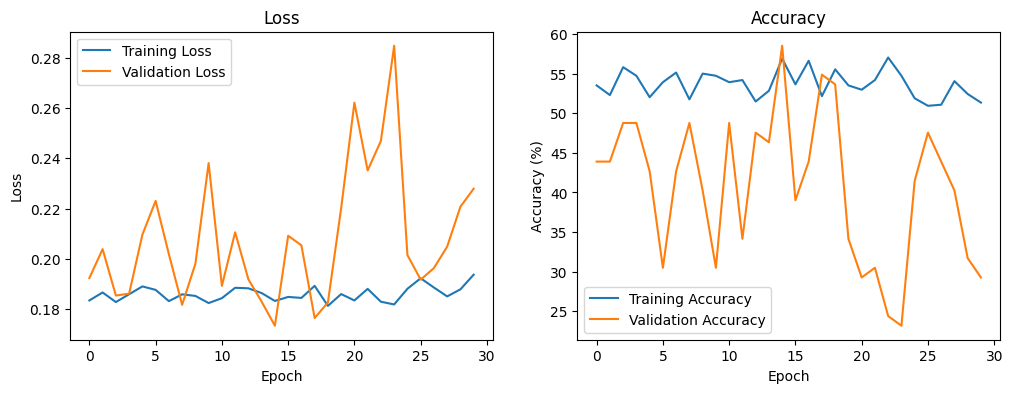

Best Validation Accuracy: 75.61% in Fold 2
Model saved to MELModel_dataAug.pt


In [36]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
# File name.
modelSaveName = "MELModel_dataAug.pt"
# model
model = CNN_Model().to(device)
# Create an optimizer.
learning_rate = 1e-3
optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate)
# Create a loss function
lossFunc = nn.CrossEntropyLoss()

BestValid_Acc = 0
Bestfold = 0
batch_size = 4
fold_loaders = create_group_kfold_loaders(dataset, batch_size, n_splits=5, dataAug=aug_dataset)
for train, test, idx in fold_loaders:
    print(f"Fold {idx}: Training samples: {len(train.dataset)}, Testing samples: {len(test.dataset)}")
    model, train_losses, train_accuracies, valid_losses, valid_accuracies = training(train, test, optimizer, num_epochs)
    print()

    # Print statistics for this fold
    all_targets = []
    all_predictions = []
    all_probs = []
    
    # Set model to evaluation mode
    model.eval()
    
    # Collect predictions for test data
    with torch.no_grad():
        for inputs, targets in test:
            # Move data to device
            inputs, targets = inputs.to(device), targets.to(device)
            
            # Forward pass
            outputs = model(inputs)
            
            # Get predictions
            _, predicted = torch.max(outputs.data, 1)
            
            # Get probability scores for ROC AUC
            probs = torch.nn.functional.softmax(outputs, dim=1).cpu().numpy()[:, 1]  # Probability for positive class
            
            # Store results for metrics calculation
            all_targets.extend(targets.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
            all_probs.extend(probs)
    
    # Calculate metrics
    try:
        roc_auc_score_value = roc_auc_score(all_targets, all_probs)
    except ValueError:
        # Handle case when only one class is present in targets
        roc_auc_score_value = 0.5
    
    # Generate confusion matrix
    cm = confusion_matrix(all_targets, all_predictions)
    
    # Print detailed metrics
    print(f"\nFold {idx} Test Results:")
    
    print(f"Classification Report:\n{classification_report(all_targets, all_predictions, zero_division=np.nan)}")
    print(f"Accuracy: {accuracy_score(all_targets, all_predictions):.4f}")
    print(f"Precision: {precision_score(all_targets, all_predictions):.4f}")
    print(f"Recall: {recall_score(all_targets, all_predictions):.4f}")
    print(f"F1 Score: {f1_score(all_targets, all_predictions):.4f}")
    print(f"ROC AUC Score: {roc_auc_score_value:.4f}")
    print(f"Confusion Matrix:\n{cm}")

    # Plot the training history
    plot_training_history(train_losses, train_accuracies, valid_losses, valid_accuracies)
    plt.show()

    # Check for best validation accuracy to store best model
    if max(valid_accuracies) > BestValid_Acc:
        BestValid_Acc = max(valid_accuracies)
        Bestfold = idx
        modelToSave = model

# 存檔
print(f"Best Validation Accuracy: {BestValid_Acc:.2f}% in Fold {Bestfold}")
torch.save(modelToSave.state_dict(), modelSaveName)
print('Model saved to %s' % modelSaveName)

Apply class weighted

weights: [0.69727891 1.76724138]
Fold 0: Training samples: 328, Testing samples: 82


Epoch: 1/30 | train loss: 0.2085 | train accuracy: 44.21%: 100%|██████████| 82/82 [00:10<00:00,  7.89it/s]
Epoch: 1/30 | valid loss: 0.1696 | valid accuracy: 60.98% : 100%|██████████| 21/21 [00:01<00:00, 13.54it/s]
Epoch: 2/30 | train loss: 0.1936 | train accuracy: 50.30%: 100%|██████████| 82/82 [00:09<00:00,  8.22it/s]
Epoch: 2/30 | valid loss: 0.1893 | valid accuracy: 51.22% : 100%|██████████| 21/21 [00:01<00:00, 12.79it/s]
Epoch: 3/30 | train loss: 0.2131 | train accuracy: 43.90%: 100%|██████████| 82/82 [00:09<00:00,  8.33it/s]
Epoch: 3/30 | valid loss: 0.2062 | valid accuracy: 36.59% : 100%|██████████| 21/21 [00:01<00:00, 14.15it/s]
Epoch: 4/30 | train loss: 0.1996 | train accuracy: 49.09%: 100%|██████████| 82/82 [00:09<00:00,  8.40it/s]
Epoch: 4/30 | valid loss: 0.1866 | valid accuracy: 57.32% : 100%|██████████| 21/21 [00:01<00:00, 14.33it/s]
Epoch: 5/30 | train loss: 0.2058 | train accuracy: 47.56%: 100%|██████████| 82/82 [00:09<00:00,  8.33it/s]
Epoch: 5/30 | valid loss: 0.1764 

d:\ancode\envs\torch\Lib\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(



Fold 0 Test Results:
Classification Report:
              precision    recall  f1-score   support

           0       0.00       nan      0.00         0
           1       1.00      0.43      0.60        82

    accuracy                           0.43        82
   macro avg       0.50      0.43      0.30        82
weighted avg       1.00      0.43      0.60        82

Accuracy: 0.4268
Precision: 1.0000
Recall: 0.4268
F1 Score: 0.5983
ROC AUC Score: nan
Confusion Matrix:
[[ 0  0]
 [47 35]]


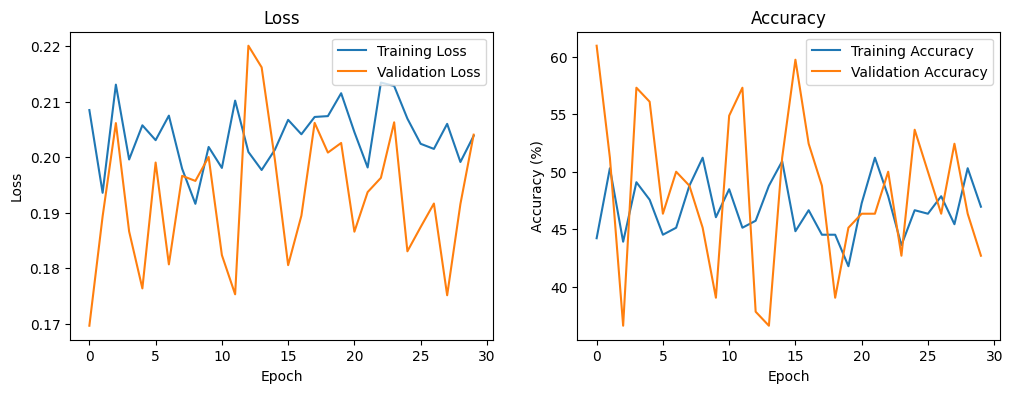

Fold 1: Training samples: 328, Testing samples: 82


Epoch: 1/30 | train loss: 0.1925 | train accuracy: 51.52%: 100%|██████████| 82/82 [00:09<00:00,  8.26it/s]
Epoch: 1/30 | valid loss: 0.1795 | valid accuracy: 50.00% : 100%|██████████| 21/21 [00:01<00:00, 14.64it/s]
Epoch: 2/30 | train loss: 0.1901 | train accuracy: 54.27%: 100%|██████████| 82/82 [00:10<00:00,  8.15it/s]
Epoch: 2/30 | valid loss: 0.1768 | valid accuracy: 65.85% : 100%|██████████| 21/21 [00:01<00:00, 14.17it/s]
Epoch: 3/30 | train loss: 0.2037 | train accuracy: 46.65%: 100%|██████████| 82/82 [00:10<00:00,  8.14it/s]
Epoch: 3/30 | valid loss: 0.1676 | valid accuracy: 62.20% : 100%|██████████| 21/21 [00:01<00:00, 14.66it/s]
Epoch: 4/30 | train loss: 0.1920 | train accuracy: 47.87%: 100%|██████████| 82/82 [00:09<00:00,  8.25it/s]
Epoch: 4/30 | valid loss: 0.1819 | valid accuracy: 59.76% : 100%|██████████| 21/21 [00:01<00:00, 14.30it/s]
Epoch: 5/30 | train loss: 0.1963 | train accuracy: 50.91%: 100%|██████████| 82/82 [00:09<00:00,  8.23it/s]
Epoch: 5/30 | valid loss: 0.1859 



Fold 1 Test Results:
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.63      0.75        75
           1       0.12      0.57      0.21         7

    accuracy                           0.62        82
   macro avg       0.53      0.60      0.48        82
weighted avg       0.87      0.62      0.71        82

Accuracy: 0.6220
Precision: 0.1250
Recall: 0.5714
F1 Score: 0.2051
ROC AUC Score: 0.6571
Confusion Matrix:
[[47 28]
 [ 3  4]]


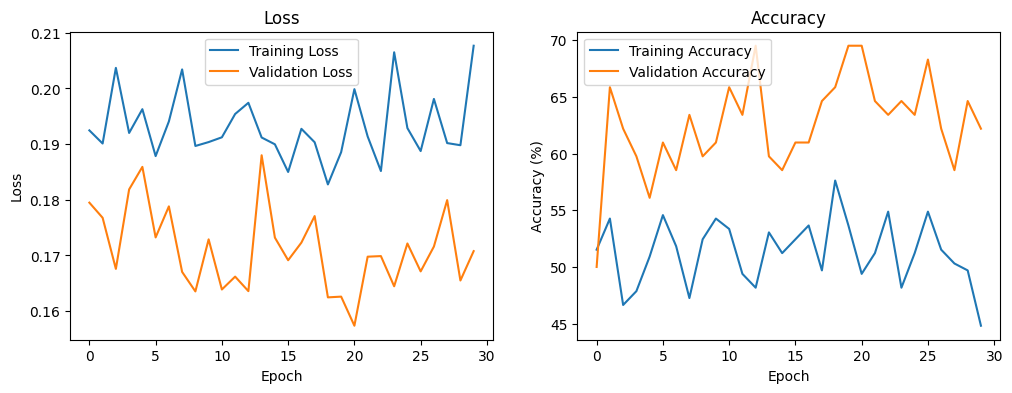

Fold 2: Training samples: 328, Testing samples: 82


Epoch: 1/30 | train loss: 0.1899 | train accuracy: 50.91%: 100%|██████████| 82/82 [00:10<00:00,  7.83it/s]
Epoch: 1/30 | valid loss: 0.1631 | valid accuracy: 68.29% : 100%|██████████| 21/21 [00:01<00:00, 13.26it/s]
Epoch: 2/30 | train loss: 0.1859 | train accuracy: 53.05%: 100%|██████████| 82/82 [00:10<00:00,  8.05it/s]
Epoch: 2/30 | valid loss: 0.1723 | valid accuracy: 68.29% : 100%|██████████| 21/21 [00:01<00:00, 14.19it/s]
Epoch: 3/30 | train loss: 0.1887 | train accuracy: 50.91%: 100%|██████████| 82/82 [00:10<00:00,  8.05it/s]
Epoch: 3/30 | valid loss: 0.1711 | valid accuracy: 64.63% : 100%|██████████| 21/21 [00:01<00:00, 14.40it/s]
Epoch: 4/30 | train loss: 0.1785 | train accuracy: 55.79%: 100%|██████████| 82/82 [00:10<00:00,  8.12it/s]
Epoch: 4/30 | valid loss: 0.1743 | valid accuracy: 63.41% : 100%|██████████| 21/21 [00:01<00:00, 13.50it/s]
Epoch: 5/30 | train loss: 0.1858 | train accuracy: 50.91%: 100%|██████████| 82/82 [00:10<00:00,  7.86it/s]
Epoch: 5/30 | valid loss: 0.1798 



Fold 2 Test Results:
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.51      0.64        73
           1       0.08      0.33      0.12         9

    accuracy                           0.49        82
   macro avg       0.47      0.42      0.38        82
weighted avg       0.77      0.49      0.58        82

Accuracy: 0.4878
Precision: 0.0769
Recall: 0.3333
F1 Score: 0.1250
ROC AUC Score: 0.4825
Confusion Matrix:
[[37 36]
 [ 6  3]]


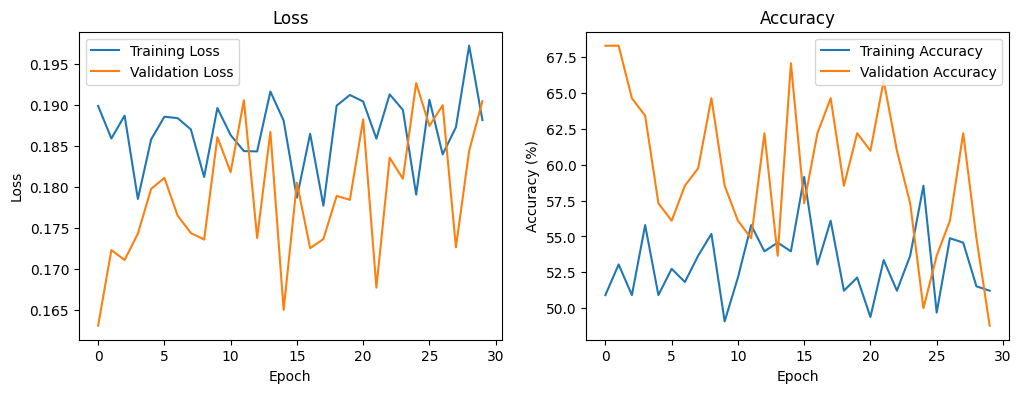

Fold 3: Training samples: 328, Testing samples: 82


Epoch: 1/30 | train loss: 0.1931 | train accuracy: 53.96%: 100%|██████████| 82/82 [00:10<00:00,  8.17it/s]
Epoch: 1/30 | valid loss: 0.1815 | valid accuracy: 43.90% : 100%|██████████| 21/21 [00:01<00:00, 14.43it/s]
Epoch: 2/30 | train loss: 0.1839 | train accuracy: 55.49%: 100%|██████████| 82/82 [00:10<00:00,  8.07it/s]
Epoch: 2/30 | valid loss: 0.2001 | valid accuracy: 37.80% : 100%|██████████| 21/21 [00:01<00:00, 14.23it/s]
Epoch: 3/30 | train loss: 0.1904 | train accuracy: 54.57%: 100%|██████████| 82/82 [00:10<00:00,  7.99it/s]
Epoch: 3/30 | valid loss: 0.1807 | valid accuracy: 48.78% : 100%|██████████| 21/21 [00:01<00:00, 14.07it/s]
Epoch: 4/30 | train loss: 0.1912 | train accuracy: 51.83%: 100%|██████████| 82/82 [00:09<00:00,  8.28it/s]
Epoch: 4/30 | valid loss: 0.1965 | valid accuracy: 39.02% : 100%|██████████| 21/21 [00:01<00:00, 14.20it/s]
Epoch: 5/30 | train loss: 0.1927 | train accuracy: 49.09%: 100%|██████████| 82/82 [00:09<00:00,  8.24it/s]
Epoch: 5/30 | valid loss: 0.1875 



Fold 3 Test Results:
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.59      0.71        73
           1       0.12      0.44      0.19         9

    accuracy                           0.57        82
   macro avg       0.51      0.52      0.45        82
weighted avg       0.81      0.57      0.65        82

Accuracy: 0.5732
Precision: 0.1176
Recall: 0.4444
F1 Score: 0.1860
ROC AUC Score: 0.5038
Confusion Matrix:
[[43 30]
 [ 5  4]]


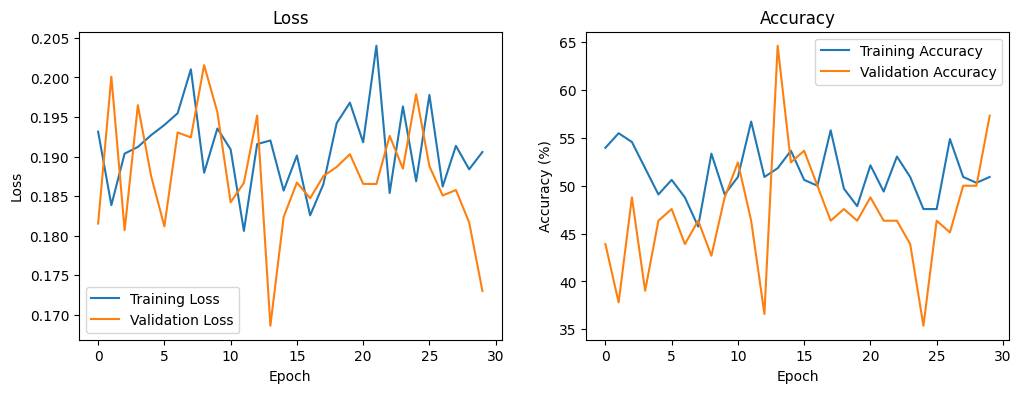

Fold 4: Training samples: 328, Testing samples: 82


Epoch: 1/30 | train loss: 0.1936 | train accuracy: 49.09%: 100%|██████████| 82/82 [00:10<00:00,  7.78it/s]
Epoch: 1/30 | valid loss: 0.2424 | valid accuracy: 18.29% : 100%|██████████| 21/21 [00:01<00:00, 13.15it/s]
Epoch: 2/30 | train loss: 0.2004 | train accuracy: 49.09%: 100%|██████████| 82/82 [00:10<00:00,  7.69it/s]
Epoch: 2/30 | valid loss: 0.2040 | valid accuracy: 37.80% : 100%|██████████| 21/21 [00:01<00:00, 13.86it/s]
Epoch: 3/30 | train loss: 0.1919 | train accuracy: 51.83%: 100%|██████████| 82/82 [00:10<00:00,  7.90it/s]
Epoch: 3/30 | valid loss: 0.2191 | valid accuracy: 31.71% : 100%|██████████| 21/21 [00:01<00:00, 13.77it/s]
Epoch: 4/30 | train loss: 0.1974 | train accuracy: 49.09%: 100%|██████████| 82/82 [00:10<00:00,  7.74it/s]
Epoch: 4/30 | valid loss: 0.2262 | valid accuracy: 28.05% : 100%|██████████| 21/21 [00:01<00:00, 13.40it/s]
Epoch: 5/30 | train loss: 0.1820 | train accuracy: 53.96%: 100%|██████████| 82/82 [00:10<00:00,  7.86it/s]
Epoch: 5/30 | valid loss: 0.2140 



Fold 4 Test Results:
Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.16      0.27        73
           1       0.08      0.56      0.13         9

    accuracy                           0.21        82
   macro avg       0.41      0.36      0.20        82
weighted avg       0.68      0.21      0.25        82

Accuracy: 0.2073
Precision: 0.0758
Recall: 0.5556
F1 Score: 0.1333
ROC AUC Score: 0.2892
Confusion Matrix:
[[12 61]
 [ 4  5]]


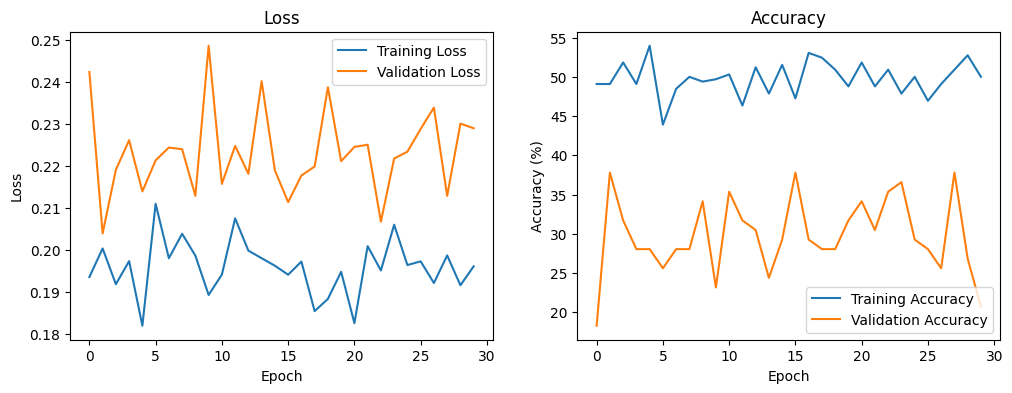

Best Validation Accuracy: 69.51% in Fold 1
Model saved to MELModel_dataaug_classweight.pt


In [37]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
# File name.
modelSaveName = "MELModel_dataaug_classweight.pt"
# model
model = CNN_Model().to(device)
# Create an optimizer.
learning_rate = 1e-6
optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate)
# Create a loss function and Apply class weight imbalance
labels = np.array([0 if int(label.split('_')[0]) < 5 else 1 for label in os.listdir(source_folder)]
                  + [0 if int(label.split('_')[1]) < 5 else 1 for label in os.listdir(aug_source_folder)])
weights = 1 / (num_classes * np.bincount(labels) / len(labels))  # Calculate class weights
print("weights:", weights)
lossFunc = nn.CrossEntropyLoss(weight=torch.Tensor(weights))

BestValid_Acc = 0
Bestfold = 0
fold_loaders = create_group_kfold_loaders(dataset, batch_size)
for train, test, idx in fold_loaders:
    print(f"Fold {idx}: Training samples: {len(train.dataset)}, Testing samples: {len(test.dataset)}")
    model, train_losses, train_accuracies, valid_losses, valid_accuracies = training(train, test, optimizer, num_epochs)
    print()

    # Print statistics for this fold
    all_targets = []
    all_predictions = []
    all_probs = []
    
    # Set model to evaluation mode
    model.eval()
    
    # Collect predictions for test data
    with torch.no_grad():
        for inputs, targets in test:
            # Move data to device
            inputs, targets = inputs.to(device), targets.to(device)
            
            # Forward pass
            outputs = model(inputs)
            
            # Get predictions
            _, predicted = torch.max(outputs.data, 1)
            
            # Get probability scores for ROC AUC
            probs = torch.nn.functional.softmax(outputs, dim=1).cpu().numpy()[:, 1]  # Probability for positive class
            
            # Store results for metrics calculation
            all_targets.extend(targets.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
            all_probs.extend(probs)
    
    # Calculate metrics
    try:
        roc_auc_score_value = roc_auc_score(all_targets, all_probs)
    except ValueError:
        # Handle case when only one class is present in targets
        roc_auc_score_value = 0.5
    
    # Generate confusion matrix
    cm = confusion_matrix(all_targets, all_predictions)
    
    # Print detailed metrics
    print(f"\nFold {idx} Test Results:")
    
    print(f"Classification Report:\n{classification_report(all_targets, all_predictions, zero_division=np.nan)}")
    print(f"Accuracy: {accuracy_score(all_targets, all_predictions):.4f}")
    print(f"Precision: {precision_score(all_targets, all_predictions):.4f}")
    print(f"Recall: {recall_score(all_targets, all_predictions):.4f}")
    print(f"F1 Score: {f1_score(all_targets, all_predictions):.4f}")
    print(f"ROC AUC Score: {roc_auc_score_value:.4f}")
    print(f"Confusion Matrix:\n{cm}")

    # Plot the training history
    plot_training_history(train_losses, train_accuracies, valid_losses, valid_accuracies)
    plt.show()

    # Check for best validation accuracy to store best model
    if max(valid_accuracies) > BestValid_Acc:
        BestValid_Acc = max(valid_accuracies)
        Bestfold = idx
        modelToSave = model


# 存檔
print(f"Best Validation Accuracy: {BestValid_Acc:.2f}% in Fold {Bestfold}")
torch.save(modelToSave.state_dict(), modelSaveName)
print('Model saved to %s' % modelSaveName)

測試模型
* inference time

In [41]:
import time
import torch
import numpy as np

# Load the model and move it to the device
model = CNN_Model().to(device)
model.load_state_dict(torch.load('./MELModel_dataAug.pt'))
model.eval()  # Set to evaluation mode

# Test data for inference
test_batch = next(iter(test_loader))[0].to(device)

# Warm-up runs
print("Warming up...")
with torch.no_grad():
    for _ in range(10):
        _ = model(test_batch)

# Measure inference time
print("Measuring inference time...")
n_iterations = 100
start_time = time.time()

with torch.no_grad():
    for _ in range(n_iterations):
        _ = model(test_batch)

end_time = time.time()

# Calculate statistics
total_time = end_time - start_time
avg_time_per_batch = total_time / n_iterations
avg_time_per_sample = total_time / (n_iterations * test_batch.size(0))

print(f"Total time for {n_iterations} iterations: {total_time:.4f} seconds")
print(f"Average time per batch: {avg_time_per_batch*1000:.2f} ms")
print(f"Average time per sample: {avg_time_per_sample*1000:.2f} ms")
print(f"Inference speed: {n_iterations * test_batch.size(0) / total_time:.2f} samples/second")

Warming up...
Measuring inference time...
Total time for 100 iterations: 2.2681 seconds
Average time per batch: 22.68 ms
Average time per sample: 5.67 ms
Inference speed: 176.36 samples/second


class weight + data augmentation's inference time

In [42]:
import time
import torch
import numpy as np

# Load the model and move it to the device
model = CNN_Model().to(device)
model.load_state_dict(torch.load('./MELModel_dataaug_classweight.pt'))
model.eval()  # Set to evaluation mode

# Test data for inference
test_batch = next(iter(test_loader))[0].to(device)

# Warm-up runs
print("Warming up...")
with torch.no_grad():
    for _ in range(10):
        _ = model(test_batch)

# Measure inference time
print("Measuring inference time...")
n_iterations = 100
start_time = time.time()

with torch.no_grad():
    for _ in range(n_iterations):
        _ = model(test_batch)

end_time = time.time()

# Calculate statistics
total_time = end_time - start_time
avg_time_per_batch = total_time / n_iterations
avg_time_per_sample = total_time / (n_iterations * test_batch.size(0))

print(f"Total time for {n_iterations} iterations: {total_time:.4f} seconds")
print(f"Average time per batch: {avg_time_per_batch*1000:.2f} ms")
print(f"Average time per sample: {avg_time_per_sample*1000:.2f} ms")
print(f"Inference speed: {n_iterations * test_batch.size(0) / total_time:.2f} samples/second")

Warming up...
Measuring inference time...
Total time for 100 iterations: 2.2403 seconds
Average time per batch: 22.40 ms
Average time per sample: 5.60 ms
Inference speed: 178.55 samples/second
